In [1]:
##########################################
#####
##### cMD and RPMD with thermostat, 
##### to settle down the internal energy.
##### Harmonic Oscillator model is used!!
#####
##########################################

##### Part 1, settings.

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

$$\begin{aligned}
\frac{p^2_n}{2mn} & = \frac{1}{2}k_{\rm{B}}T \\
\end{aligned}$$

In [2]:
##### Part 2, useful subroutines.
##### pot: The harmonic potential
##### Verlet_step: A single Velocity Verlet step.
#####


def pot(x):
    k = 0.5
    x0= 1.0
    V = 0.5*k*(x-x0)**2
    dV = k*(x-x0)
    return V,dV

def use_fft(Y_in):
    Y_out = np.fft.fft(Y_in)
    sp4 = np.zeros(len(Y_out))
    N_half = np.int(len(Y_out)/2)
    for i in range(0,N_half+1,1):
        sp4[i] = np.real(Y_out[i])
    i2 = 0
    for i in range(N_half+1,len(Y_out)):
        i2 += 1
        j = N_half-i2
        sp4[i] = np.imag(Y_out[j])
    return sp4

def use_ifft(sp4):
    Ntot = len(sp4)
    Y_out = np.zeros(Ntot,dtype=np.complex)
    N_half = np.int(np.float(Ntot)/2.0)
    for i in range(N_half+1):
        if i == 0 or i == N_half:
            pt2 = 0.0
        else:
            pt2 = sp4[-i]
        Y_out[i] = np.complex(sp4[i],0)+np.complex(0,pt2)
    for i in range(N_half+1,Ntot,1):
        pt1 = sp4[Ntot - i]
        Y_out[i] = np.complex(pt1,0) + np.complex(0,-sp4[i])
    Y_in = np.fft.ifft(Y_out)
    return np.real(Y_in)
        

def free_ring_polymer(q,p,Nbeads,mass,dt,beta):
    #print("Now come into the free ring polymer.")
    #print("Original q, p: ")
    #print(q)
    #print(p)
    q = use_fft(q)
    p = use_fft(p)
    #print("Transformed q, p: ")
    #print(q)
    #print(p)
    
    poly=np.zeros((4,Nbeads))
    
    poly[0,0] = 1.0E0
    poly[1,0] = 0.0E0
    poly[2,0] = dt / mass
    poly[3,0] = 1.0E0
    
    N_half = np.int(np.float(Nbeads) / 2.0)
    if (Nbeads > 1):
        beta_n = beta / np.float(Nbeads)
        twown = 2.0E0 / beta_n
        pi_n = np.pi / np.float(Nbeads)
        
        for k in range(0, N_half):
            #print("k: ",k)
            j = k+1
            wk = twown * np.sin(j * pi_n)
            wt = wk * dt
            wm = wk * mass
            cos_wt = np.cos(wt)
            sin_wt = np.sin(wt)
            poly[0,j] = cos_wt
            poly[1,j] = -wm*sin_wt
            poly[2,j] = sin_wt/wm
            poly[3,j] = cos_wt
            
        N_half2 = np.int(np.floor(np.float(Nbeads - 1) / 2.0))
        for k in range(1, N_half2+1):
            #print("Second loop, k: ",k)
            poly[0,Nbeads-k] = poly[0,k]
            poly[1,Nbeads-k] = poly[1,k]
            poly[2,Nbeads-k] = poly[2,k]
            poly[3,Nbeads-k] = poly[3,k]

        #print(poly)
        for k in range(Nbeads):
            p_new = p[k] * poly[0,k] + q[k] * poly[1,k]
            q_new = p[k] * poly[2,k] + q[k] * poly[3,k]
            p[k] = p_new
            q[k] = q_new
    
   
    q = use_ifft(q)
    p = use_ifft(p)
    #print("Back transformed q, p: ")
    #print(q)
    #print(p)
    #print("Leaving free ring polymer")
    return q, p


def Verlet_step(x,p,dt,mass,Nbeads,beta):
    #### x = x(Nbeads),
    #### p = p(Nbeads)
    #print("x: ",x )
    for k in range(Nbeads):
        #print("x[k]:",x[k])
        V, dV = pot(x[k])
        p[k] = p[k] - 0.5*dt*dV
    
    if Nbeads == 1:
        x = x + p*dt/mass
    else:
        x,p = free_ring_polymer(x,p,Nbeads,mass,dt,beta)
    
    for k in range(Nbeads):
        V, dV = pot(x[k])
        p[k] = p[k] - 0.5*dt*dV
        
    return x, p


def init_p(Temperature,Nbeads):
    fact = 0.00000316678
    TT = Temperature * fact ## In a.u.
    pref = np.sqrt(TT*mass*Nbeads) ### 
    mu = 0.0
    sigma = 1.0
    
    p_init = np.zeros(Nbeads)
    for k in range(Nbeads):
        p_init[k] = np.random.normal(mu, sigma)
        p_init[k] = p_init[k] * pref  #### Initial momentum.
    
    return p_init

def MD_run(x_init, p_init, Nstep, N_andersen, dt, mass, Nbeads,beta):
    #### x_init and p_init are both vectors!!

    X_traj=np.zeros((Nstep,Nbeads))
    P_traj=np.zeros((Nstep,Nbeads))
    T_traj=np.zeros(Nstep)
    X_Centroid_traj = np.zeros(Nstep)
    P_Centroid_traj = np.zeros(Nstep)

    x = np.zeros(Nbeads)
    p = np.zeros(Nbeads)
    for istep in range(Nstep):

        x, p = Verlet_step(x_init, p_init, dt, mass,Nbeads,beta)
        #print("x: ",x)
        #print("p: ",p)
        
        Xc = 0.0
        Pc = 0.0
        for k in range(Nbeads):
            X_traj[istep,k]=(x[k])
            P_traj[istep,k]=(p[k])
            Xc += x[k]
            Pc += p[k]
        X_Centroid_traj[istep] = Xc/np.float(Nbeads)
        P_Centroid_traj[istep] = Pc/np.float(Nbeads)
        T_traj[istep]=(istep*dt)

        ##### Andersen thermostat.
        if istep % N_andersen == 0:
            p = init_p(Temperature,Nbeads) ##### Regenerate new momenta after the Andersen time interval.
        
        x_init=x[:]
        p_init=p[:]
        
    return X_traj, P_traj, T_traj, X_Centroid_traj, P_Centroid_traj



$$\begin{aligned}
\omega = \sqrt{\frac{k}{m}} = \sqrt{0.5/2000.0} = 0.015811
\end{aligned}$$

$T = 63.2471$

$\Delta t \le 6.3 $

$$\begin{aligned}
T_{\rm{c}} & = \frac{\hbar \omega}{2\pi k_{\rm{B}}} \\
& = 0.015811/ (2.0\times \pi k_{\rm{B}}) \\
& = 0.0025 \, \, (\rm{a.u.}) \\
& = 795 \, \, {\rm{K}} \\
\end{aligned}$$

$$\begin{aligned}
N_{\rm{min}} & = \beta \hbar \omega \\
& = \omega /0.00000316678*T \\
& = 0.015811/0.00000316678*T  \\
& = 17 \, \, (300\, \, {\rm{K}}) \\
& = 2 \, \, (3000\, \, {\rm{K}}) \\
& = 1664 \, \, (3\, \, {\rm{K}}) \\
& = 6.2 \, \, (800\, \, {\rm{K}}) \\
\end{aligned}$$




$$\begin{aligned}
\langle q^2\rangle_{\rm{Classical}} & = \frac{k_{\rm{B}}T}{m\omega^2} \\
& = \frac{T}{k} \\
& = \frac{800.0 \times 0.00000316678}{0.5} \\
& = 0.00506685 \\
\end{aligned}$$

$$\begin{aligned}
{\rm{STD}}_{q,\rm{Classical}} & = \sqrt{ \langle q^2\rangle_{\rm{Classical}} -
\langle q\rangle^2_{\rm{Classical}}} \\
& = \sqrt{0.00506685} \\
& = 0.0712 \\
\end{aligned}$$


$$\begin{aligned}
\langle q^2\rangle_{\rm{quantum}} & = \frac{\hbar}{2m\omega}{\rm{coth}}(\frac{\beta \hbar \omega}{2}) \\
& = \frac{1}{2 m \omega} {\rm{coth}}(\frac{\omega}{2 k_{\rm{B}}T} ) \\
& = \frac{1}{2\times 2000.0 \times 0.0158114}{\rm{coth}}(\frac{0.5\times 0.0158114}{800.0 \times 0.00000316678}) \\
& = 0.0158731 \\
\end{aligned}$$

$$\begin{aligned}
{\rm{STD}}_{q,\rm{quantum}} & = \sqrt{ \langle q^2\rangle_{\rm{quantum}} -
\langle q\rangle^2_{\rm{quantum}}} \\
& = \sqrt{0.0158731} \\
& = 0.125988 \\
\end{aligned}$$

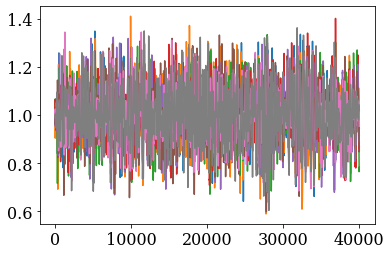

bead average std:  0.11249596221265215
centroid std:  0.07389834849539176


In [5]:
### Part 3: Run!

mass = 2000.0

Nbeads = 8
x_init = np.ones(Nbeads) ##### Initial position: 0.0.


Temperature = 800.0     ###### Temperature, in Kelvin.
p_init = init_p(Temperature,Nbeads)

constants_kB = 1.3806504e-23
beta = 4.35974417e-18 / (constants_kB * Temperature)
fact = 0.00000316678
TT = Temperature * fact ## In a.u.
##print(beta,1/TT)
######################################
dt = 2 ##### In a.u.
######################################

######################################
Nstep = 20000 ##### Evolution steps.
######################################


##### Setting of the thermostat.
N_andersen = np.int(np.sqrt(np.float(Nstep))) ##### Normal Andersen interval.
######################################

X_traj, P_traj, T_traj,X_Centroid_traj, P_Centroid_traj = \
MD_run(x_init, p_init, Nstep, N_andersen, dt, mass,Nbeads,beta)
 
for k in range(Nbeads):
    plt.plot(T_traj,X_traj[:,k],'-')
plt.show()

### Print out the STD of beads and centroid.

N_reject = 2000

std_bead_ave = 0.0
for k in range(Nbeads):
    std_bead_ave += np.std(X_traj[N_reject:,k])
std_bead_ave = std_bead_ave / np.float(Nbeads)

std_centroid = np.std(X_Centroid_traj[N_reject:])

print("bead average std: ",std_bead_ave )
print("centroid std: ", std_centroid)

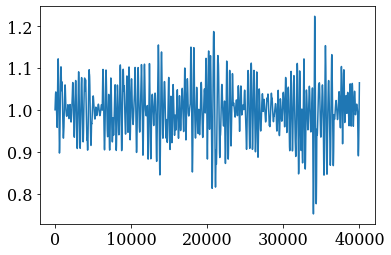

bead average std:  0.06259511948436734
centroid std:  0.0636710401820312


In [6]:
### Part 3: Run!

mass = 2000.0

Nbeads = 1
x_init = np.ones(Nbeads) ##### Initial position: 0.0.


Temperature = 800.0     ###### Temperature, in Kelvin.
p_init = init_p(Temperature,Nbeads)

constants_kB = 1.3806504e-23
beta = 4.35974417e-18 / (constants_kB * Temperature)
fact = 0.00000316678
TT = Temperature * fact ## In a.u.
#print(beta,1/TT)
######################################
dt = 2 ##### In a.u.
######################################

######################################
Nstep = 20000 ##### Evolution steps.
######################################


##### Setting of the thermostat.
N_andersen = np.int(np.sqrt(np.float(Nstep))) ##### Normal Andersen interval.
######################################

X_traj_1b, P_traj_1b, T_traj_1b,X_Centroid_traj_1b, P_Centroid_traj_1b = \
MD_run(x_init, p_init, Nstep, N_andersen, dt, mass,Nbeads,beta)
 
for k in range(Nbeads):
    plt.plot(T_traj_1b,X_traj_1b[:,k],'-')
plt.show()

### Print out the STD of beads and centroid.

N_reject = 2000



std_centroid_1b = np.std(X_Centroid_traj_1b[N_reject:])

print("bead average std: ",np.std(X_traj_1b[:,0]) )
print("centroid std: ", std_centroid_1b)